# 线性回归
## 1. 基本原理
### 1.1 线性回归的基本元素
引入：

  我们希望根据房屋的面积（平⽅英尺）和房龄（年）来估算房屋价格（美元）。为了开发⼀个能预测房价的模型，我们需要收集⼀个真实的数据集，其中包括了房屋的销售价格、面积和房龄。
- 我们把这样的一个真实数据集称为训练集，每行数据称为样本（n）
- 特征 $x$（feaures）：面积、房龄
- 标签 $y$（labels）：价格
$$price = w_1 area + w_2 age + b$$
- 矩阵表示：
$$\hat{y} = Xw + b$$
- 建立模型 -> 寻找最佳模型参数 -> 还需要：

（1）一种模型质量的度量方式（损失函数）；

（2）一种能更新模型以提高模型预测质量的方式（随机梯度下降）

### 1.2 损失函数 
- 作用：量化标签实际值与预测值之间的差距，一般用非负数表示，数值越小则损失越小，损失为0代表完美预测
- 残差平方和：$$l_i(\mathbf{w},b) = \frac{1}{2}(\hat{y_i} - y_i) ^ 2$$
- 由于函数存在平方项，估计值和观测值之间较大的差异将导致更大的损失，为了度量模型在整个数据集上的质量，需计算在训练集n个样本上的损失均值：
$$L(\mathbf{w},b) = \frac{1}{n}\sum_{i=1}^{n}l_i(\mathbf{w},b)$$
- 训练时希望得到一组参数使得在整个数据集上的损失最小，即：
$$\mathbf{w}^*,b^* = argmin_{\mathbf{w},b} L(\mathbf{w},b)$$

### 1.3 随机梯度下降
- 梯度下降法：在损失函数递减的方向上更新参数来降低误差，其中$\eta$为学习率
$$(\mathbf{w},b) \gets (\mathbf{w},b) - \eta\sum_{i} \partial_{(\mathbf{w},b)}l_i(\mathbf{w},b)$$
- 推导：https://zhuanlan.zhihu.com/p/36564434

梯度下降最简单的用法是遍历整个数据集来更新参数，这样的做法在实际执行中非常慢。因此使用随机梯度下降法：
- 每次更新前随机抽取一个小批量样本B，它是由固定数量的训练样本组成，然后我们计算这个小批量样本的平均损失来更新参数
$$(\mathbf{w},b) \gets (\mathbf{w},b) - \frac{\eta}{B}\sum_{i\in B} \partial_{(\mathbf{w},b)}l_i(\mathbf{w},b)$$
- 批量大小B和学习率$\eta$通常都是手动设定，而不是由模型训练得到，这些可以调整但不在训练过程中更新的参数叫做超参数，选择超参数的过程称为调参

### 1.4 线性回归的深度网络
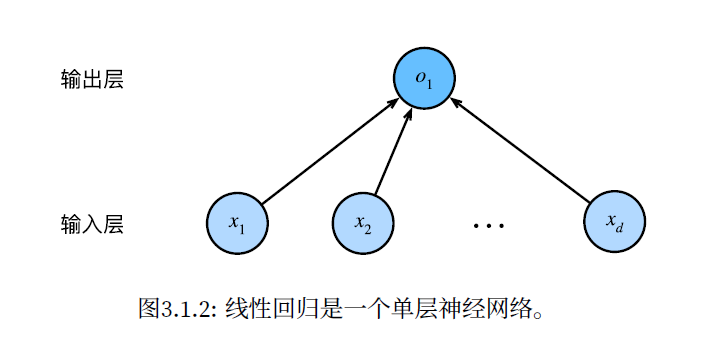
在图3.1.2所示的神经网络中，输入为$x_1,...,x_d$，即输入层中的特征维度（输入数量）为d；输出为$o_1$，即输出层中的输出数量为1
- 单层神经网络：输入层与输出层仅发生一次变换
- 全链接层：每个输入都与输出相连

## 2. 代码实现
### 2.1 矢量化加速
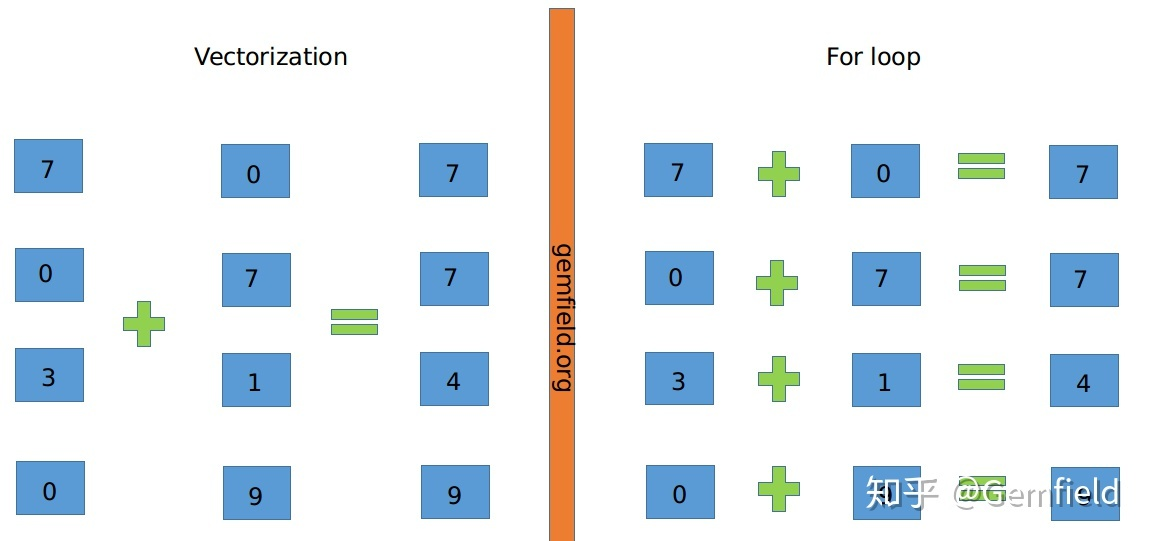

In [1]:
import time
import torch

In [2]:
# 定义计时器
class Timer():
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        self.tik = time.time() # 记录启动时刻
        
    def stop(self):
        self.times.append(time.time() - self.tik) #将时间添加到列表的最后面
        return self.times[-1] #读取列表的最后一个元素

In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)
c= torch.zeros(n)

In [4]:
# 标量计算用时
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

#矢量化计算用时
timer.start()
d = a + b 
print(f'{timer.stop():.5f} sec')

0.07902 sec
0.00000 sec


### 2.2 线性回归的从零开始实现
步骤回顾：
- 小批量读取数据集
- 初始化模型参数
- 定义模型、损失函数、优化算法
- 更新参数（训练）
- 评估

#### 2.2.1 生成数据集

In [5]:
%matplotlib inline
import random
import torch

In [4]:
# 基于y=Xw+b+kesi，生成（X,y）的数据集
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b # 广播机制
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

In [7]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.6393,  1.6135]) 
label: tensor([-2.5405])


#### 2.2.2 小批量读取数据集

In [8]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 获取样本数量
    indices = list(range(num_examples)) 
    random.shuffle(indices) # 打乱列表顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)]) # 按batch_size的步长切片
        yield features[batch_indices], labels[batch_indices] # 随机读取batch_size的features和labels

In [9]:
# 示例
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1366, -2.2183],
        [ 0.0695,  1.5080],
        [-0.9755,  0.3766],
        [ 1.5987,  0.4475],
        [-1.2538,  0.5133],
        [-1.6587, -0.1509],
        [ 0.3864,  1.9414],
        [-0.3006, -2.6354],
        [-0.5709, -0.6858],
        [-0.5449, -1.6084]]) 
 tensor([[11.4710],
        [-0.7866],
        [ 0.9574],
        [ 5.8852],
        [-0.0474],
        [ 1.3982],
        [-1.6159],
        [12.5536],
        [ 5.4055],
        [ 8.5771]])


#### 2.2.3 初始化模型参数

In [10]:
w = torch.normal(0, 0.01, size = (2,1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

#### 2.2.4 定义模型、损失函数、优化算法

In [11]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y): 
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

#### 2.2.5 训练
在每次迭代中，我们读取⼀⼩批量训练样本，并通过我们的模型来获得⼀组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法sgd来更新模型参数。
概括一下，我们将执行以下循环：
- 初始化参数
- 重复以下训练直到结束
    - 计算梯度：$\mathbf{g} \gets \partial_{(\mathbf{w},b)} \frac{1}{B}\sum_{i\in B} l_i(\mathbf{x_i}, y_i, \mathbf{w}, b)$
    - 更新参数：$(\mathbf{w},b) \gets (\mathbf{w},b) - \eta\mathbf{g}$

In [12]:
lr = 0.03 # 设置学习率
num_epochs = 3 # 设置迭代周期
net = linreg # 设置模型
loss = squared_loss #设置损失函数

In [14]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels): #读取数据集
        l = loss(net(X, w, b), y) # 计算参数更新前的损失函数
        l.sum().backward() # 计算梯度
        sgd([w, b], lr, batch_size) # 更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) # 计算参数更新后的损失函数
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()):f}')

epoch1, loss0.000108
epoch2, loss0.000044
epoch3, loss0.000044


In [15]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0004, -0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


### 2.3 线性回归的简洁实现
#### 2.3.1 生成数据集

In [1]:
import numpy as np
import torch
from torch.utils import data

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

#### 2.3.2 读取数据集

In [9]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [10]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-0.3363, -0.0815],
         [ 0.3680,  1.2607],
         [-1.7209, -1.2253],
         [-0.0612,  0.1515],
         [-0.8216,  0.0203],
         [ 0.0306, -0.8378],
         [ 0.7215,  0.6380],
         [ 2.0758,  1.0722],
         [-1.8942,  0.2127],
         [-0.0786,  0.8096]]),
 tensor([[ 3.7966],
         [ 0.6423],
         [ 4.9265],
         [ 3.5582],
         [ 2.4730],
         [ 7.1158],
         [ 3.4702],
         [ 4.7259],
         [-0.3174],
         [ 1.3036]])]

#### 2.3.3 定义模型并初始化参数

In [11]:
from torch import nn

In [12]:
net = nn.Sequential(nn.Linear(2, 1))

In [13]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

#### 2.3.4 定义损失函数、优化算法

In [14]:
loss = nn.MSELoss()

In [15]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

#### 2.3.5 训练

In [16]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch{epoch + 1}, loss{l:f}')

epoch1, loss0.000171
epoch2, loss0.000097
epoch3, loss0.000096


In [ ]:
w = net[0].weight.data
print('w的估计误差:',true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

具体讲解：https://blog.csdn.net/weixin_50774105/article/details/117412095?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522166815299916782391824133%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=166815299916782391824133&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~blog~sobaiduend~default-1-117412095-null-null.nonecase&utm_term=next%28iter%28data_iter%29%29&spm=1018.2226.3001.4450